![header](https://i.ibb.co/kHXgpXS/Bitcoin-Banner-1900-x-500.jpg)

# Cryptocurrency Time Series
***
Authors: [TJ Bray](https://www.linkedin.com/in/thomas-tj-bray-24499354/), [Aalok Joshi](https://www.linkedin.com/in/aalokjoshi113/), [Paul Lindquist](https://www.linkedin.com/in/paul-lindquist/)

## Overview
***
Time series is, quite simply, a series of data points indexed over time. Time series analysis is used to extract meaningful statistics, patterns, etc. from time series data, while time series forecasting uses a model to predict future values based on previously observed data. We encounter time series in our everyday lives in the form of outside temperatures, home values and stock prices, all over time.

Stock price forecasting has generally limited success, as factors like purchase volume and current events can cause price fluctuations. Can the same be said of cryptocurrency, namely the heavily traded Bitcoin? In this project, we use traditional time series analysis and forecasting to predict Bitcoin prices.

We choose Bitcoin for 2 reasons:

- Greatest gross price of all cryptocurrencies
- Trading popularity (volume)

## Business Objective
***
This project postulates that we are cryptocurrency traders speaking to our stakeholders, Future Crypto Investors of America, a group of young, future investors. We briefly outline our process for selecting the best performing model and quickly jump into the results. We give particular focus to comparing predicted vs. actual prices using past data and provide accompanying visualizations. We expect this to both highlight performance and encourage future investment.

We take a daily, predictive approach to forecast if the Bitcoin price will increase, decrease or stay flat. We then subsequently provide guidance to buy, sell or hold that day.

## Data
***
This project uses [datasets](https://www.kaggle.com/yamqwe/cryptocurrency-extra-data-bitcoin) from Kaggle user [Yam Peleg](https://www.kaggle.com/yamqwe) created for the ***[G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting)*** competition.

## Methodology
***
We employ time series analysis and predictive modeling for the forecasting.

## Library Imports
***

In [94]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import statsmodels.api as sm

%matplotlib inline

## Data Imports and Concatenation
***

Here we create a function that specifys the coin and year of the data we want. As a default, we get the bitoin 2017 data.
The function opens the file, sets the timestamp as the index, sorts the index oldest to newest and keeps the columns we can use for analysis.

In [95]:
def get_data(coin = 'bitcoin', year = 2017):
    
    df = pd.read_csv(f'./data/{coin}_{year}.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')
    df.set_index('timestamp', inplace = True)
    df.sort_index(inplace = True)
    df = df[['Count','Open','High','Low','Close','Volume','VWAP','Target']]
    
    return df

In [96]:
#get all the years available for the analysis

btc2017 = get_data()
btc2018 = get_data('bitcoin', 2018)
btc2019 = get_data('bitcoin', 2019)
btc2020 = get_data('bitcoin', 2020)
btc2021 = get_data('bitcoin', 2021)

In [97]:
#Concatenate the dataframes into one final bitcoin dataframe.
btc = pd.concat([btc2017, btc2018, btc2019, btc2020, btc2021], axis = 0)

## Data Cleaning and Exploratory Data Analysis
***

The intital dataframes have minute by minute data of the asset. However, for our analysis we want the ability to use different time periods. Here we create a function, "resample", that allows us to choose how we want to resample the data. When resampling the data, we needed to use different periods of the day to get the proper data for our new sample sizes. For the open price, we need the opening price of the first minute. For the close we need the closing price of last minute. For Volume, we need to use the sum of all of the minutes throughout the day.

In [98]:
def resample(df, time_period = '1d'):
    df1 = df[['Open']].resample(time_period).first()
    df2 = df[['Close']].resample(time_period).last()
    df3 = df[['Volume']].resample(time_period).sum()
    df = pd.concat([df1,df2,df3], axis = 0).sort_index().groupby('timestamp').sum()
    return df

In order to give ourselves the best possible dataset, we create techinical analysis indicators. With the data we were given (and the timeframe of our project) we were create simple moving averages, the distance of the closing price from the simple moving average, the volatility of the asset from past periods, and the rolling trading volume of the asset. We shift all the datapoints one day so that the data from the day before aligned with the price of the day we would be trying to predict. This keeps the end of day data from leaking into the price we're trying to predict.

In [99]:
def add_cols(df):
    
    #Logging the data is very common in financial data do to it's proclivity for outliers and skewness.
    #logging the opening and closing prices helps us make the historical prices more normally distributed. 
    df['log_open'] = np.log(df['Open'])
    df['log_close'] = np.log(df['Close'])

    #Logging the return and shifting allows us to normalize the returns, this also makes the returns additive
    #rather than multiplicative.
    df['return'] = np.log(df['Close']/df['Close'].shift(1)).shift(1)
    
    #Knowing the close of the asset price over the last 7 days can be beneficial in predicting the price of
    #the next day
    for i in range(7):
        days_ago = f'close_{i+1}_prior'
        df[days_ago] = df['log_close'].shift(i+1)
    
    #The simple moving average of the closing price of the asset helps smooth the data. It can help determine
    #whether the price will continue moving in a certain diretion or change course. 
    df['sma_7'] = df['Close'].rolling(7).mean().shift(1)
    df['sma_30'] = df['Close'].rolling(30).mean().shift(1)
    df['sma_50'] = df['Close'].rolling(50).mean().shift(1)
    df['sma_200'] = df['Close'].rolling(200).mean().shift(1)

    #The distance between the closing price and the simple moving average can help identify possible reversals
    #in price direction. Crossovers can prove valuable in determining the sentiment of the asset.
    df['dist_sma_7'] = (df['Close'] - df['sma_7']).shift(1)
    df['dist_sma_30'] = (df['Close'] - df['sma_30']).shift(1)
    df['dist_sma_50'] = (df['Close'] - df['sma_50']).shift(1)
    df['dist_sma_200'] = (df['Close'] - df['sma_200']).shift(1)
    
    #Momentum is a measure that shows how strong an asset is moving in a particular direction. Stronger values
    #mean the current trend is likely to continue.
    df['momentum_7'] = df['return'].rolling(7).mean().shift(1)
    df['momentum_30'] = df['return'].rolling(30).mean().shift(1)
    df['momentum_50'] = df['return'].rolling(50).mean().shift(1)
    df['momentum_200'] = df['return'].rolling(200).mean().shift(1)
    
    #This shows the degress at which prives move. Asssets that are highly volatile are riskier (such as crypto-
    #currencies).
    df['volatility_7'] = df['return'].rolling(7).std().shift(1)
    df['volatility_30'] = df['return'].rolling(7).std().shift(1)
    df['volatility_50'] =  df['return'].rolling(50).std().shift(1)
    df['volatility_200'] = df['return'].rolling(200).std().shift(1)
    
    #The volume of trades can confirm the momentum of the stock or alert for the possibility of a reversal.
    df['volume_7'] = df['Volume'].rolling(7).mean().shift(1)
    df['volume_14'] = df['Volume'].rolling(14).mean().shift(1)
    df['volume_30'] = df['Volume'].rolling(30).mean().shift(1)
    df['volume_50'] = df['Volume'].rolling(50).mean().shift(1)
    
    df['Volume'] = df['Volume'].shift(1)

    df.dropna(inplace = True)
    
    return df

In [100]:
#running the bitcoin minute by minute data through our functions to get our final data frame.
daily = add_cols(resample(btc))

In [101]:
#in order to create a training set and a testing set, we use only the data until October 1, 2021 to train our models.
daily = daily[daily.index <= '10-1-2021']
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1183 entries, 2018-07-07 to 2021-10-01
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            1183 non-null   float64
 1   Close           1183 non-null   float64
 2   Volume          1183 non-null   float64
 3   log_open        1183 non-null   float64
 4   log_close       1183 non-null   float64
 5   return          1183 non-null   float64
 6   close_1_prior   1183 non-null   float64
 7   close_2_prior   1183 non-null   float64
 8   close_3_prior   1183 non-null   float64
 9   close_4_prior   1183 non-null   float64
 10  close_5_prior   1183 non-null   float64
 11  close_6_prior   1183 non-null   float64
 12  close_7_prior   1183 non-null   float64
 13  sma_7           1183 non-null   float64
 14  sma_30          1183 non-null   float64
 15  sma_50          1183 non-null   float64
 16  sma_200         1183 non-null   float64
 17  dist_sma_7     

Below we see the trends of each column through the history of our training data. Bitcoin specifically has had large fluctuations in the price throughout it's history, generally in a 4 year cycle. As you can see in the volatility, momentum, and volume plots, there tends to be a lot of fluctuation in investor sentiment towards bitcoin.

Just glancing at the data, we can see that among the pricing values, return seems to the most stationary. The other values have really been affected by the upward trend of early 2020. 

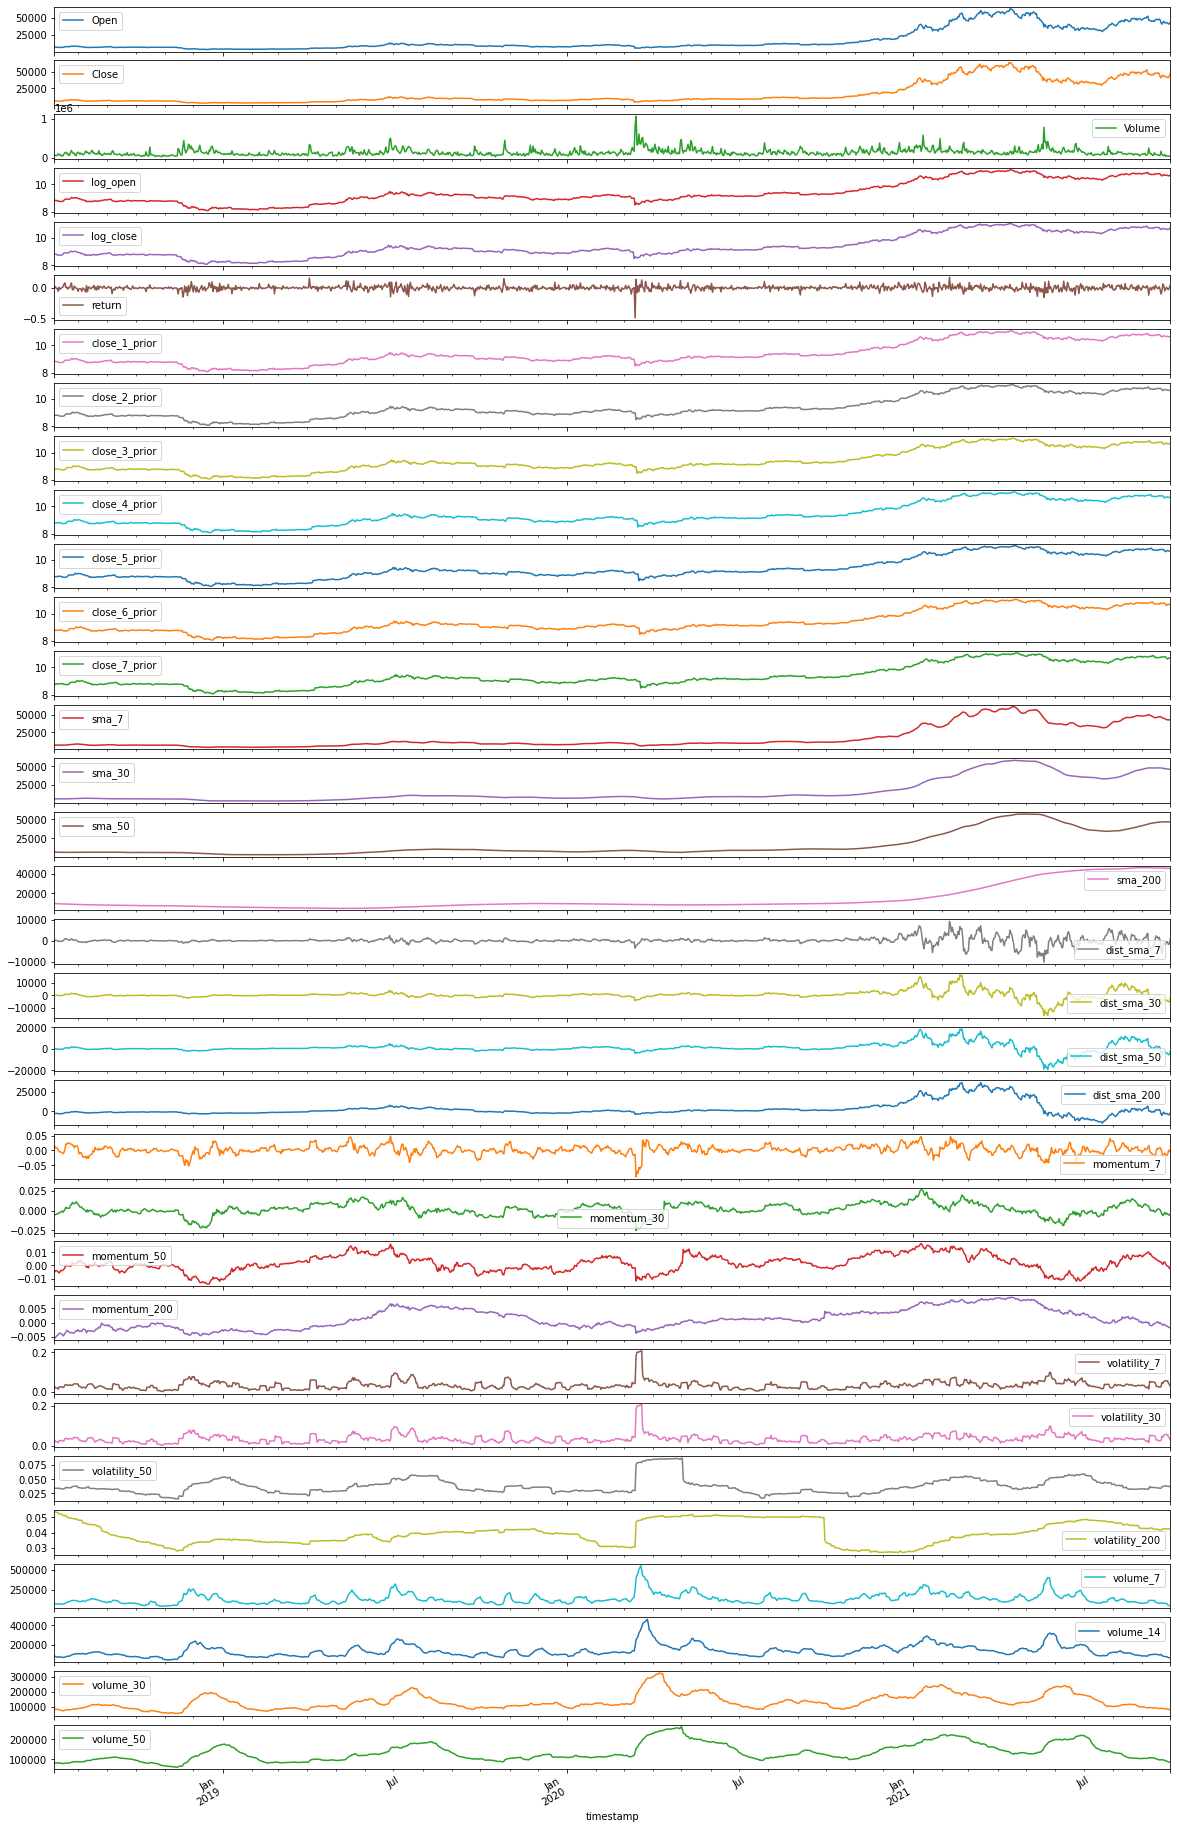

In [102]:
daily.plot(figsize=(20,36), subplots=True, legend=True);

### Historical Price Chart
This chart of the prices shows the smoothing effects simple moving average has on the data. There are large price fluctuations in the daily closing price, however, the 30 day simple moving average and 200 day simple moving average are much smoother.

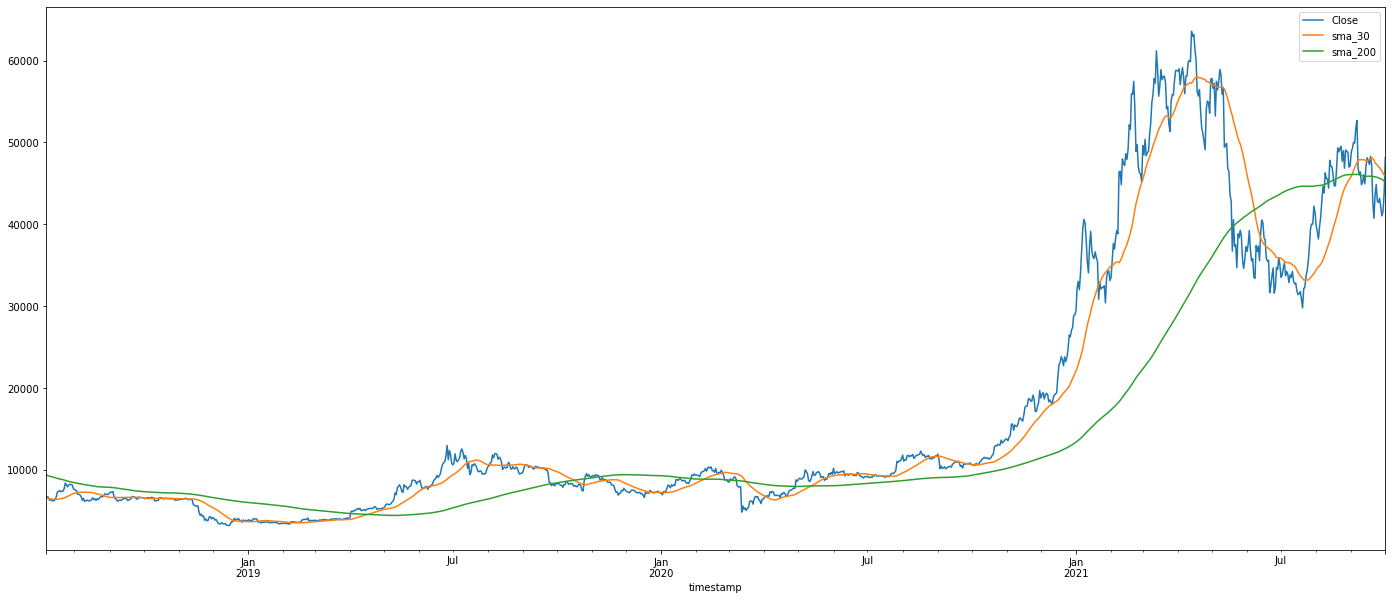

In [103]:
daily[['Close', 'sma_30', 'sma_200']].plot(figsize = (24,10));

In [104]:
corrs = daily.corr().stack().reset_index()
corrs.columns = ['1','2','R2']
temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
correlations = temp[temp.index % 2 == 0]
correlations.head(20)

,1,2,R2
0,close_2_prior,log_open,0.998798
2,close_1_prior,close_2_prior,0.998797
4,close_3_prior,close_2_prior,0.998797
6,close_3_prior,close_4_prior,0.998795
8,log_close,close_1_prior,0.998794
10,log_close,log_open,0.998794
12,close_4_prior,close_5_prior,0.998793
14,close_6_prior,close_5_prior,0.998790
16,close_6_prior,close_7_prior,0.998788
18,Open,Close,0.998123


Dickey-Fuller Log Closing Price score: -0.1479351834285181
Dickey-Fuller Log Closing Price p-value: 0.9444497119176376


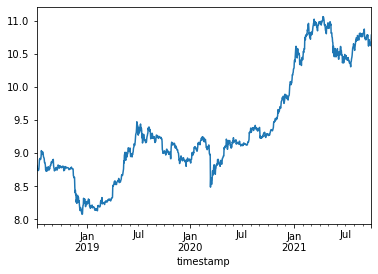

In [105]:
adf_log_close = adfuller(daily['log_close'])
print(f'Dickey-Fuller Log Closing Price score: {adf_log_close[0]}')
print(f'Dickey-Fuller Log Closing Price p-value: {adf_log_close[1]}')
daily['log_close'].plot();

Dickey-Fuller Log Closing Price Differenced p-value: -16.018349523485337
Dickey-Fuller Log Closing Price Differenced p-value: 6.244362021739663e-29


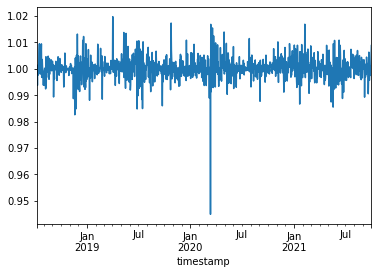

In [106]:
daily['log_close_diff'] = (daily['log_close']/daily['log_close'].shift(1))
adf_log_close_diff = adfuller(daily['log_close_diff'].dropna())
print(f'Dickey-Fuller Log Closing Price Differenced p-value: {adf_log_close_diff[0]}')
print(f'Dickey-Fuller Log Closing Price Differenced p-value: {adf_log_close_diff[1]}')
daily['log_close_diff'].plot();

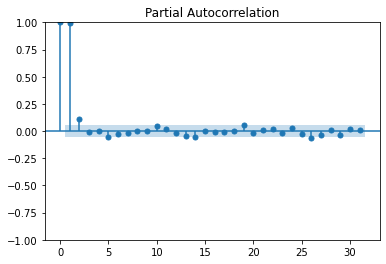

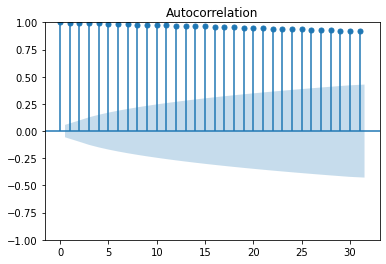

In [107]:
plot_pacf(daily['log_close']);
plot_acf(daily['log_close']);

In [108]:
def decomposition_plot(ts):
        '''Takes time series dataframe and decompose it in order to observe trend, seasonality, and residuals'''
        decomposition = tsa.seasonal_decompose(ts, period = 7, model = 'multiplicative')
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        plt.figure(figsize=(10,7))
        plt.subplot(511)
        plt.plot(ts, label='Original', color='red')
        plt.legend(loc='best')
        plt.subplot(512)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(513)
        plt.plot(seasonal,label='Seasonality', color='orange')
        plt.legend(loc='best')
        plt.subplot(514)
        plt.plot(residual, label='Residuals', color='black')
        plt.legend(loc='best')
        plt.tight_layout()
        
        return decomposition

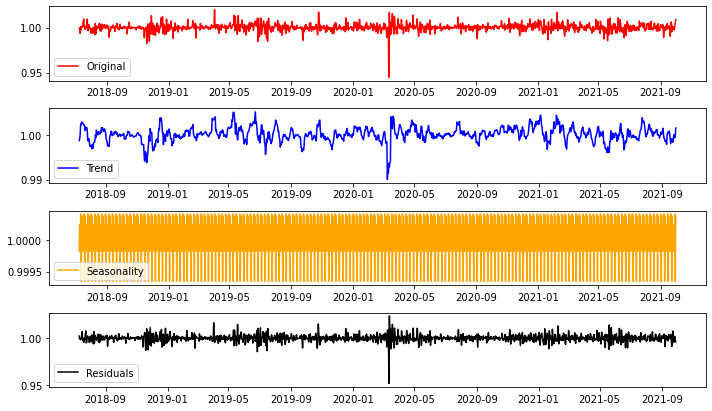

In [109]:
decomp = decomposition_plot(daily['log_close_diff'].dropna())

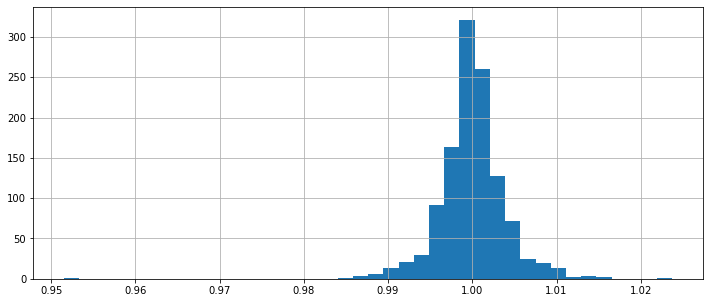

In [110]:
decomp.resid.hist(figsize = (12,5), bins = 40);

## Modeling
***

Here we run 6 traditional time series models.

We set aside data beginning October 1, 2021 as our test data for predictions (forecasting). We train our models on the preceding data (January 1, 2017 - September 30, 2021).

After fitting the training data to our models, we look at the root mean square error (RMSE) of each model, which is used to measure the differences between the predicted prices and the actual (observed) prices.

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

### White Noise

We fit a white noise model to our training data to test for complete randomness and noise within the data.

The lag observations (p), differencing (d) and size of the moving average (q) are all set to 0.

In [111]:
def white_noise_model(df):

    y = df['log_close']

    train_size = [len(y),500,250,100,50]
        
    aic_scores = []

    for size in train_size:
        model = ARIMA(endog = y.tail(size), order =(0,0,0))
        fitmodel = model.fit()
        rmse = np.sqrt(fitmodel.mse)
        aic_scores.append(pd.DataFrame(['white noise', size, (0,0,0), fitmodel.aic, rmse]).T)
                
    wn_df = pd.concat(aic_scores, axis = 0)
    wn_df.set_axis(['model type', 'train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = wn_df.sort_values(['train_size', 'RMSE'], ascending = [False, True]).reset_index(drop = True)
    
    return return_df

In [112]:
white_noise = white_noise_model(daily)

***For all of our models, we will select the lowest RMSE value with a train size of 1183, which is the entirety of our training data. We provide different train size options because in a real-world environment, there most likely isn't the time or computational alotment provided to train a model on an entire, multi-year dataset and various sliding windows (50 days, 100 days, etc.) will need to be employed.***

Fortunately the model returns a RMSE value (0.8186) and the .describe() summary confirms and non-one mean and non-zero standard deviation, meaning the data isn't just noise.

In [113]:
white_noise

,model type,train_size,order,AIC,RMSE
0,white noise,1183,"(0, 0, 0)",2887.71,0.818628
1,white noise,500,"(0, 0, 0)",1033.87,0.677689
2,white noise,250,"(0, 0, 0)",-90.3136,0.200375
3,white noise,100,"(0, 0, 0)",-80.6923,0.158437
4,white noise,50,"(0, 0, 0)",-137.416,0.0588304


In [114]:
daily.log_close.describe()

count    1183.000000
mean        9.367095
std         0.818974
min         8.073619
25%         8.814396
50%         9.146786
75%         9.862619
max        11.059911
Name: log_close, dtype: float64

### Random Walk

We fit a random walk model to our training data to check for randomness in differences but not the series itself.

The p and q values are set to 0 with the differencing (d) set to 1.

In [115]:
def random_walk_model(df, for_backtest = False):

    y = df['log_close']

    train_size = [len(y),500,250,100,50]
        
    aic_scores = []

    for size in train_size:
        model = ARIMA(endog = y.tail(size), order =(0,1,0))
        fitmodel = model.fit()
        rmse = np.sqrt(fitmodel.mse)
        aic_scores.append(pd.DataFrame(['random walk', size, (0,1,0), fitmodel.aic, rmse]).T)
                
    rw_df = pd.concat(aic_scores, axis = 0)
    rw_df.set_axis(['model type','train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = rw_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    if for_backtest == True:
        best_model = ARIMA(endog = y.tail(return_df['train_size'][0]), order =(0,1,0))
        best_fit_model = best_model.fit()
        return best_fit_model
    
    else:
        return return_df

In [116]:
random_walk = random_walk_model(daily)

Here we can see the results are much more closely aligned with our data, yielding a lower 0.2595 RMSE value than the previous white noise model. We'll see if we can do better...

In [117]:
random_walk

,model type,train_size,order,AIC,RMSE
0,random walk,1183,"(0, 1, 0)",-4239.22,0.259502
1,random walk,500,"(0, 1, 0)",-1829.92,0.41147
2,random walk,250,"(0, 1, 0)",-847.585,0.658064
3,random walk,100,"(0, 1, 0)",-369.34,1.04598
4,random walk,50,"(0, 1, 0)",-179.364,1.52432


### Random Walk with Drift

We fit a random walk with a drift model to our training data. Similar to the previous random walk model, the time series itself isn't completely random but the differences between the series are random and this time, there's a coefficient (represented as 'c') that adds a drift.

The p and d values are again set to 0 with a differencing (d) of 1.

In [118]:
def random_walk_drift_model(df):

    y = df['log_close']
    
    train_size = [len(y),500,250,100,50]
        
    aic_scores = []

    for size in train_size:
        model = ARIMA(endog = y.tail(size), order =(0,1,0), trend = 'c')
        fitmodel = model.fit()
        rmse = np.sqrt(fitmodel.mse)
        aic_scores.append(pd.DataFrame(['random walk drift', size, (0,1,0), fitmodel.aic, rmse]).T)
                
    rwd_df = pd.concat(aic_scores, axis = 0)
    rwd_df.set_axis(['model type','train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = rwd_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    return return_df

In [66]:
random_walk_drift = random_walk_drift_model(daily)

ValueError: In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing operation). For example, a constant cannot be included in an ARIMA(1, 1, 1) model, but including a linear trend, which would have the same effect as fitting a constant to the differenced data, is allowed.

Again, the model yields a lower RMSE value than the white noise model, indicating a better overall fit.

In [119]:
random_walk_drift

,model type,train_size,order,AIC,RMSE
0,random walk drift,1183,"(0, 1, 0)",-4239.24,0.259449
1,random walk drift,500,"(0, 1, 0)",-1831.47,0.411313
2,random walk drift,250,"(0, 1, 0)",-845.918,0.657961
3,random walk drift,100,"(0, 1, 0)",-368.136,1.04565
4,random walk drift,50,"(0, 1, 0)",-177.365,1.5243


### ARMA

We fit an autoregressive moving average (ARMA) model. We don't know which lag observations or moving average values yield the best performing model so we set up a loop to iterate through 36 different model combinations of p and q values.

***Please note, we won't be able to use this as our best and final model, as our data isn't stationary and there's no differencing (d) value built into the order to deal with the lack of stationarity.***

In [120]:
def ARMA_model(df):

    y = df['log_close']
    
    aic_scores = []

    train_size = [len(y),500,250,100,50]

    for p in range(6):
        for q in range(6):
            for size in train_size:
                model = ARIMA(endog = y.tail(size), order =(p,0,q))
                fitmodel = model.fit()
                rmse = np.sqrt(fitmodel.mse)
                aic_scores.append(pd.DataFrame(['ARMA', size, (p,0,q), fitmodel.aic, rmse]).T)
                    
    arma_df = pd.concat(aic_scores, axis = 0)
    arma_df.set_axis(['model type', 'train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = arma_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    return return_df

In [121]:
arma = ARMA_model(daily)

An order of (1, 0, 5) yields the lowest RMSE value among any models that we've fit thus far. Unfortunately, as stated above, we can't use this as our final model.

In [122]:
arma

,model type,train_size,order,AIC,RMSE
0,ARMA,1183,"(1, 0, 5)",-4241.41,0.04296
1,ARMA,1183,"(1, 0, 4)",-4243.06,0.0429616
2,ARMA,1183,"(2, 0, 5)",-4239.42,0.0429618
3,ARMA,1183,"(3, 0, 4)",-4238.93,0.0429636
4,ARMA,1183,"(5, 0, 0)",-4243.52,0.0429664
...,...,...,...,...,...
175,ARMA,50,"(0, 0, 3)",-181.742,0.0352752
176,ARMA,50,"(1, 0, 0)",-184.285,0.0358394
177,ARMA,50,"(0, 0, 2)",-181.044,0.0362533
178,ARMA,50,"(0, 0, 1)",-172.595,0.0403063


### ARIMA

We fit an autoregressive integrated moving average (ARIMA) model to our training data. It's the same as an ARMA model except the differencing value (d) is non-zero. Again, we set up a loop to iterate through 27 different model combinations of p, d and q values (using a smaller range this time).

In [123]:
def ARIMA_model(df):
    
    y = df['log_close']

    aic_scores = []

    train_size = [len(y),500,250,100,50]

    for p in range(3):
        for d in range(1,4):
            for q in range(3):
                for size in train_size:
                    model = ARIMA(endog = y.tail(size), order =(p,d,q))
                    fitmodel = model.fit()
                    rmse = np.sqrt(fitmodel.mse)
                    aic_scores.append(pd.DataFrame(['ARIMA', size, (p,d,q), fitmodel.aic, rmse]).T)
                    
    arima_df = pd.concat(aic_scores, axis = 0)
    arima_df.set_axis(['model type', 'train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = arima_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    return return_df


In [124]:
arima = ARIMA_model(daily)

Since we can't use the ARMA model, this ARIMA model yields the lowest RMSE value (0.2594) and is our final, best performing model.

In [125]:
arima

,model type,train_size,order,AIC,RMSE
0,ARIMA,1183,"(2, 1, 2)",-4249.53,0.259454
1,ARIMA,1183,"(1, 1, 1)",-4251.09,0.25946
2,ARIMA,1183,"(2, 1, 1)",-4248.3,0.259462
3,ARIMA,1183,"(2, 1, 0)",-4250.29,0.259462
4,ARIMA,1183,"(1, 1, 2)",-4247.79,0.259464
...,...,...,...,...,...
130,ARIMA,50,"(1, 3, 2)",-136.585,2.17242
131,ARIMA,50,"(0, 3, 1)",-140.467,2.17242
132,ARIMA,50,"(2, 3, 0)",-127.24,2.17258
133,ARIMA,50,"(1, 3, 0)",-112.971,2.1729


### ARIMAX

In [126]:
def ARIMAX_model(df, test_size = 3):
    
    df = df.drop(['Close', 'log_close_diff'], axis =1)
    
    x = df.drop('log_close', axis = 1)
    y = df['log_close']

    aic_scores = []

    train_size = [len(y),500,250,100,50]

    for p in range(3):
        for d in range(1,4):
            for q in range(3):
                for size in train_size:
                    model = ARIMA(endog = y.tail(size), exog = x.tail(size), order =(p,d,q))
                    fitmodel = model.fit()
                    rmse = np.sqrt(fitmodel.mse)
                    aic_scores.append(pd.DataFrame(['ARIMAX', size, (p,d,q), fitmodel.aic, rmse]).T)
                    
    arimax_df = pd.concat(aic_scores, axis = 0)
    arimax_df.set_axis(['model type','train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = arimax_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    return return_df

In [127]:
arimax = ARIMAX_model(daily)

In [128]:
arimax

,model type,train_size,order,AIC,RMSE
0,ARIMAX,1183,"(1, 1, 2)",-4212.75,0.262356
1,ARIMAX,1183,"(1, 1, 1)",-4214.75,0.262356
2,ARIMAX,1183,"(2, 1, 0)",-4214.75,0.262356
3,ARIMAX,1183,"(0, 1, 1)",-4216.75,0.262356
4,ARIMAX,1183,"(1, 1, 0)",-4216.75,0.262356
...,...,...,...,...,...
130,ARIMAX,50,"(2, 3, 0)",-128.135,20.1224
131,ARIMAX,50,"(0, 3, 1)",-128.813,20.1224
132,ARIMAX,50,"(1, 3, 1)",-126.811,20.1224
133,ARIMAX,50,"(1, 3, 0)",-128.79,20.1224


### Identify Model with Best RMSE

In [129]:
models = pd.concat([random_walk, random_walk_drift, arima, arimax], axis = 0)

In [130]:
models = models.sort_values(['train_size','RMSE'], ascending = [False,True])

In [131]:
models.head(10)

,model type,train_size,order,AIC,RMSE
0,random walk drift,1183,"(0, 1, 0)",-4239.24,0.259449
0,ARIMA,1183,"(2, 1, 2)",-4249.53,0.259454
1,ARIMA,1183,"(1, 1, 1)",-4251.09,0.25946
2,ARIMA,1183,"(2, 1, 1)",-4248.3,0.259462
3,ARIMA,1183,"(2, 1, 0)",-4250.29,0.259462
4,ARIMA,1183,"(1, 1, 2)",-4247.79,0.259464
5,ARIMA,1183,"(0, 1, 2)",-4249.76,0.259464
6,ARIMA,1183,"(1, 1, 0)",-4248.08,0.259473
7,ARIMA,1183,"(0, 1, 1)",-4246.84,0.259477
0,random walk,1183,"(0, 1, 0)",-4239.22,0.259502


### Best Model Selection

In [132]:
best_model = ARIMA(endog = daily['log_close'], order =(2,1,2))
best_model_fit = best_model.fit()
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              log_close   No. Observations:                 1183
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2129.764
Date:                Wed, 05 Jan 2022   AIC                          -4249.528
Time:                        22:58:36   BIC                          -4224.153
Sample:                    07-07-2018   HQIC                         -4239.963
                         - 10-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3693      0.159      2.323      0.020       0.058       0.681
ar.L2          0.5504      0.166      3.318      0.001       0.225       0.876
ma.L1         -0.4558      0.168     -2.720      0.0

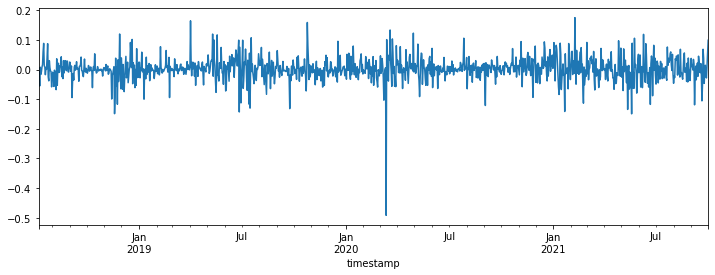

In [133]:
best_model_fit.resid[1:].plot(figsize = (12,4));

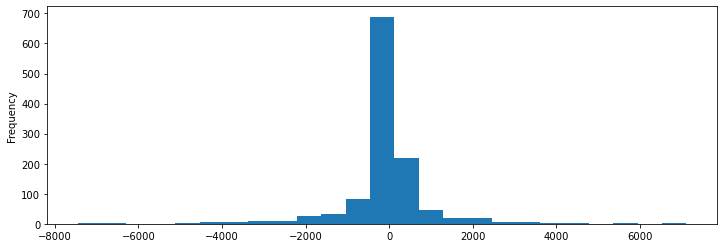

In [134]:
residuals = np.exp(best_model_fit.fittedvalues) - (daily['Close'])
residuals.plot(kind = 'hist', figsize = (12,4), bins = 25);

## Forecasting
***

In [135]:
daily_test = add_cols(resample(btc))
daily_test.head()

,Open,Close,Volume,log_open,log_close,return,close_1_prior,close_2_prior,close_3_prior,close_4_prior,...,momentum_50,momentum_200,volatility_7,volatility_30,volatility_50,volatility_200,volume_7,volume_14,volume_30,volume_50
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-07-07,6602.941429,6752.501429,64816.596403,8.795270,8.817668,0.010569,8.794999,8.784430,8.792935,8.780534,...,-0.004886,-0.005302,0.027785,0.027785,0.033861,0.053411,74896.827362,80062.843292,83779.893017,81538.060967
2018-07-08,6755.638333,6704.184286,54711.884869,8.818133,8.810487,0.022669,8.817668,8.794999,8.784430,8.792935,...,-0.003996,-0.005248,0.020892,0.020892,0.033667,0.053421,70545.218843,79090.881971,83599.824901,81075.744116
2018-07-09,6706.365000,6661.478571,55112.312012,8.810812,8.804097,-0.007181,8.810487,8.817668,8.794999,8.784430,...,-0.003979,-0.004703,0.019881,0.019881,0.033680,0.053145,70893.331436,73388.811688,83643.323221,81209.998621
2018-07-10,6662.305714,6302.410000,63555.762763,8.804221,8.748687,-0.006390,8.804097,8.810487,8.817668,8.794999,...,-0.004111,-0.004500,0.020048,0.020048,0.033679,0.053057,67323.079659,71106.155748,84323.605457,81369.042204
2018-07-11,6303.092857,6379.651667,97041.676048,8.748796,8.760869,-0.055409,8.748687,8.804097,8.810487,8.817668,...,-0.004927,-0.004220,0.014203,0.014203,0.033217,0.052898,70074.414081,73684.409544,81923.513076,82075.280369


In [136]:
def predictions(df, start_date = '2021-10-1', days_to_predict = 30, forecast_days = 1):
    
    date = datetime.strptime(start_date, '%Y-%m-%d')
    
    d = pd.date_range(start = date, end = date + timedelta(days_to_predict))

    data = df['log_close']
    y = data
    
    predictions = []
    
    for date in d:
       
        y = data[data.index < date]
        
        model = ARIMA(endog = y, order =(2,1,2))
        fitmodel = model.fit()
        y_pred = fitmodel.forecast(forecast_days)
        predictions.append([date, np.exp(y_pred)])
        print(y_pred.transpose())
    
    preds = pd.DataFrame(predictions, columns = ['timestamp', 'prediction']).set_index('timestamp')
    
    df2 = df.merge(preds, on = 'timestamp')
    
    pred_plot = df2[['Open','Close','prediction']]
    pred_plot['Close'].plot(figsize = (20,8),color = 'k')
    pred_plot['prediction'].plot(color = 'red', linewidth = 4, linestyle = '--')
    
    return df2

2021-10-01    10.682904
2021-10-02    10.685409
2021-10-03    10.683677
Freq: D, Name: predicted_mean, dtype: float64
2021-10-02    10.775694
2021-10-03    10.780960
2021-10-04    10.779487
Freq: D, Name: predicted_mean, dtype: float64
2021-10-03    10.776831
2021-10-04    10.774400
2021-10-05    10.777297
Freq: D, Name: predicted_mean, dtype: float64
2021-10-04    10.780816
2021-10-05    10.783718
2021-10-06    10.783528
Freq: D, Name: predicted_mean, dtype: float64
2021-10-05    10.805631
2021-10-06    10.806435
2021-10-07    10.807626
Freq: D, Name: predicted_mean, dtype: float64
2021-10-06    10.846178
2021-10-07    10.850505
2021-10-08    10.850036
Freq: D, Name: predicted_mean, dtype: float64


TypeError: no numeric data to plot

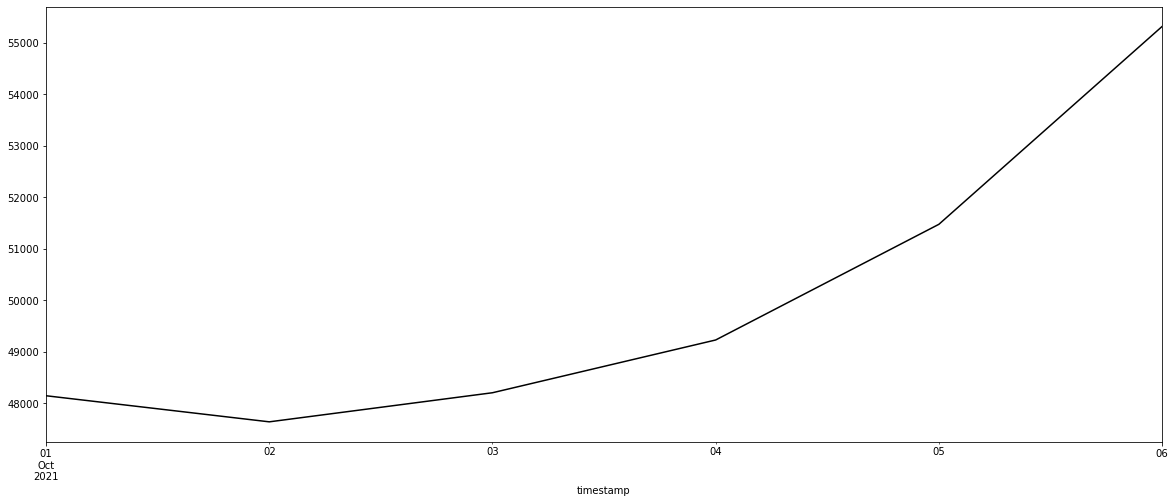

In [137]:
one_day_preds = predictions(daily_test, start_date = '2021-10-1', days_to_predict = 5, forecast_days = 3)

In [ ]:
one_day_preds[['Open','Close','prediction']]

## Results
***
TBD

## Conclusions and Next Steps
***
TBD

For next steps, we would like to explore the following:

- Time series analysis and forecasting for Ether (the 2nd largest cryptocurrency commonly known as Ethereum)
- A time-intensive and computationally expensive, iterative, predictive modeling approach to Bitcoin price using various sliding windows
- Compare the time series modeling approach to other machine learning algorithms (random forest, XGBoost, etc.)
- Develop a trading strategy to maximize returns